<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Этапы выполнения проекта**
1.	Загрузим и подготовим данные. Поясним порядок действий.
2.	Исследуем баланс классов, обучим модель без учёта дисбаланса. Кратко опишем выводы.
3.	Улучшим качество модели, учтем дисбаланс классов. Обучим разные модели и найдем лучшую. Кратко опишем выводы.
4.	Проведем финальное тестирование.

**Описание данных**
Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). Скачать датасет
Признаки

•	RowNumber — индекс строки в данных

•	CustomerId — уникальный идентификатор клиента

•	Surname — фамилия

•	CreditScore — кредитный рейтинг

•	Geography — страна проживания

•	Gender — пол

•	Age — возраст

•	Tenure — сколько лет человек является клиентом банка

•	Balance — баланс на счёте

•	NumOfProducts — количество продуктов банка, используемых клиентом

•	HasCrCard — наличие кредитной карты

•	IsActiveMember — активность клиента

•	EstimatedSalary — предполагаемая зарплата

**Целевой признак**

•	Exited — факт ухода клиента


## Подготовка данных

In [1]:
! pip install -q imblearn

In [2]:
# Импортируем необходимые библиотеки и избавимся от предупреждений
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import f1_score, mean_absolute_error, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
pd.options.mode.chained_assignment = None

In [3]:
# Загрузим данные
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('Churn.csv')

Проверим, что данные загружены и посмотрим общую информацию о них

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [7]:
# Избавимся от лишней информации, так как в нашем случае она не несет в себе полезной информации
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)

In [8]:
# Пропуски в столбце Tenure скорее всего означают отсутствие продуктов банка у клиента. Заменим эти значения нулем.
df['Tenure'].fillna(0, inplace=True)

In [9]:
# Задействуем технику прямого кодирования, чтобы преобразовать категориальные признаки в численные.
df_ohe = pd.get_dummies(df, drop_first=True)

In [10]:
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [11]:
# Разобьем получившийся датасет на 3 выборки - обучающую, валидационную и тестовую
target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

features_train, features_rest, target_train, target_rest = train_test_split(
    features, target, test_size=0.4, random_state=777, stratify=df['Exited']
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_rest, target_rest, test_size=0.5, random_state=777
)

In [12]:
# Выведем выборки на экран
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


In [13]:
# Масштабируем признаки
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Вывод:**
1. загрузили и изучили данные
2. обработали данные:
    - избавились от столбцов RowNumber, CustomerId, Surname
    - заменили NaN-значения в столбце Tenure на 0
    - столбцы Geography и Gender преобразовали в численные с помощью One-Hot Encoding
3. разбили датасет на 3 выборки - обучающую, валидационную и тестовую
4. масштабировали признаки методом стандартизации

## Исследование задачи

In [14]:
# Напишем общую функцию для логистической регрессии    
def logistic_regression_func(features, target, features_valid, target_valid, class_weight):
    global accuracy_lr
    global predicted_valid_lr
    global model  

    try:
        pipe = Pipeline([
                ('scale', StandardScaler()),
                ('model', LogisticRegression(random_state=777, solver='lbfgs', class_weight=class_weight))])

        parameters = {'model__solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}

        model = GridSearchCV(pipe, param_grid=parameters, cv=3, n_jobs=1, verbose=2, scoring='f1')
        model.fit(features, target)

        predicted_valid_lr = pd.Series(model.best_estimator_.predict(features_valid))
        probabilities_valid = model.best_estimator_.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        accuracy_lr = model.best_estimator_.score(features_valid, target_valid)

        print("Лучший вариант модели:", model.best_estimator_)
        print("Лучшие параметры:", model.best_params_)
        print("Лучшее качество по accuracy на валидации:", accuracy_lr)
        print("ROC-AUC метрика на валидации:", roc_auc_score(target_valid, probabilities_one_valid))
        print("F1-мера по кроссвалидации:", model.best_score_)

        return model.best_estimator_, model.best_params_, predicted_valid_lr

    except Exception as e:
        print('Ошибка в методе logistic_regression_func:', e)
        return None, None

In [15]:
# Напишем общую функцию для случайного леса
def rand_forest_func(features, target, class_weight):
    best_accuracy = 0
    best_depth = 0
    best_proba = 0
    best_f1 = 0
    
    try:
        for depth in tqdm(range(1,10)):
            for est in range(5,45,5):
                for sample in range(2,5):
                    model = RandomForestClassifier(max_depth=depth, n_estimators=est, 
                                min_samples_leaf=sample, random_state=777, class_weight=class_weight)
                    model.fit(features, target)
                    predicted_valid_rf = pd.Series(model.predict(features_valid))
                    accuracy = model.score(features_valid, target_valid)
                    probabilities_valid = model.predict_proba(features_valid)
                    f1 = f1_score(target_valid, predicted_valid_rf)

                    if f1 > best_f1:
                        best_f1 = f1
                        best_accuracy = accuracy
                        best_depth = depth
                        best_est = est
                        best_sample = sample
                        best_proba = probabilities_valid

        probabilities_one_valid = best_proba[:, 1]
    except:
        print('Ошибка в методе rand_forest_func')
        
    print("Оптимальная глубина дерева:", best_depth)
    print("Оптимальное количество деревьев:", best_est)
    print("Минимум объектов в узле:", best_sample)
    print("Лучшее качество:", best_accuracy)
    print("F1-мера:", best_f1)
    print("ROC-AUC метрика:", roc_auc_score(target_valid, probabilities_one_valid))
    
    return predicted_valid_rf;

Обучим модели и измерим accuracy

In [16]:
logistic_regression_func(features_train, target_train, features_valid, target_valid, None)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ............................model__solver=newton-cg; total time=   0.2s
[CV] END ............................model__solver=newton-cg; total time=   0.2s
[CV] END ............................model__solver=newton-cg; total time=   0.3s
[CV] END ................................model__solver=lbfgs; total time=   0.1s
[CV] END ................................model__solver=lbfgs; total time=   0.2s
[CV] END ................................model__solver=lbfgs; total time=   0.2s
[CV] END ............................model__solver=liblinear; total time=   0.1s
[CV] END ............................model__solver=liblinear; total time=   0.2s
[CV] END ............................model__solver=liblinear; total time=   0.2s
[CV] END ..................................model__solver=sag; total time=   0.1s
[CV] END ..................................model__solver=sag; total time=   0.2s
[CV] END ..................................model_

(Pipeline(steps=[('scale', StandardScaler()),
                 ('model',
                  LogisticRegression(random_state=777, solver='newton-cg'))]),
 {'model__solver': 'newton-cg'},
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1995    0
 1996    0
 1997    0
 1998    0
 1999    0
 Length: 2000, dtype: int64)

In [17]:
predicted_valid_rf = rand_forest_func(features_train, target_train, None)

100%|██████████| 9/9 [00:22<00:00,  2.47s/it]

Оптимальная глубина дерева: 9
Оптимальное количество деревьев: 25
Минимум объектов в узле: 4
Лучшее качество: 0.866
F1-мера: 0.593939393939394
ROC-AUC метрика: 0.8537889932072859


Доля правильных ответов — 87%. Нам необходимо понять, хороший ли это результат.

Посмотрим на распределение наших признаков для ушедших и оставшихся клиентов:

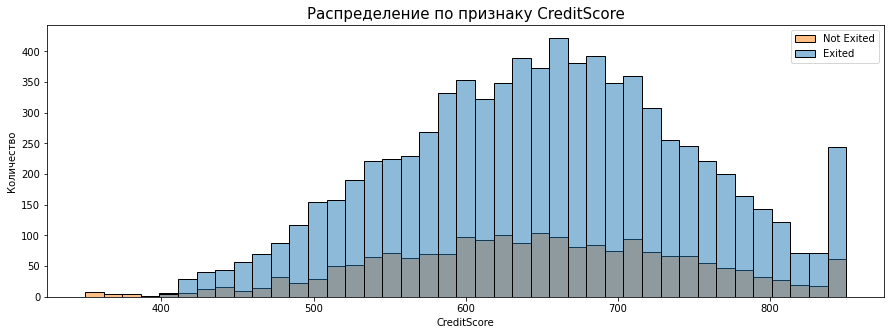

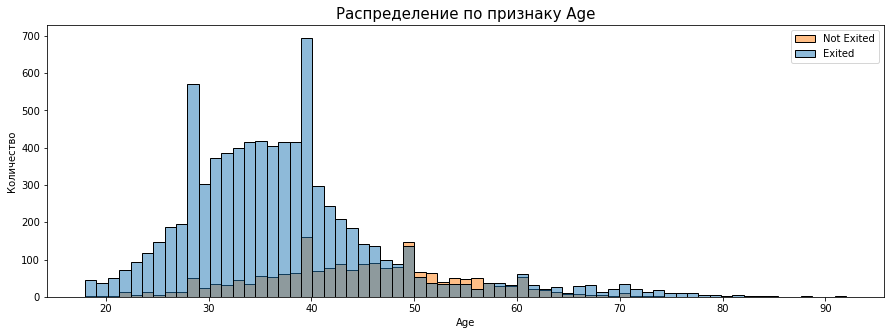

In [18]:
for column in ['CreditScore', 'Age']:
    plt.figure(figsize=(15,5))
    ax = sns.histplot(data=df, x=df[column], hue='Exited')
    ax.set_title('Распределение по признаку ' +column, fontsize=15, color='black')
    plt.ylabel('Количество', fontsize = 10, color='black')
    plt.xlabel(column, fontsize=10, color='black')
    ax.legend(['Not Exited', 'Exited'], loc=1, fontsize=10)
plt.show()

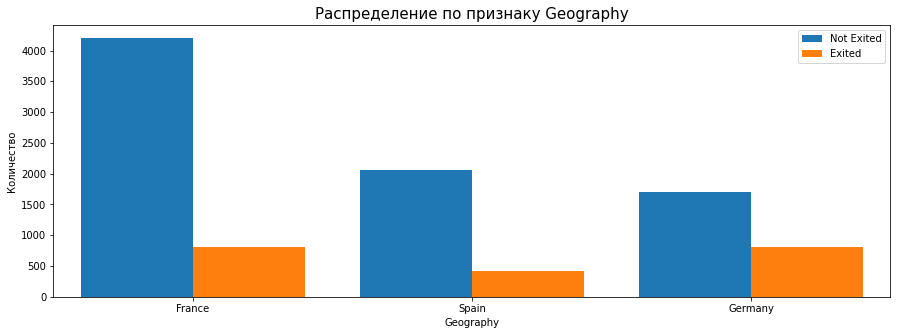

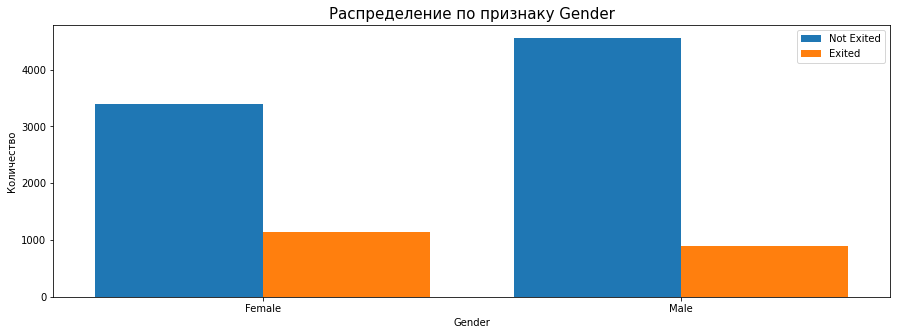

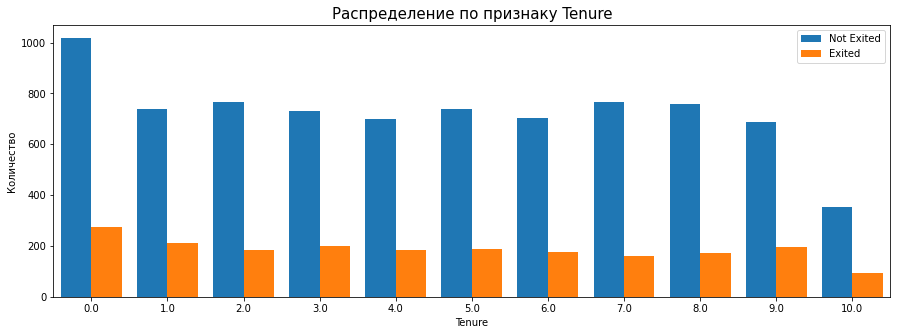

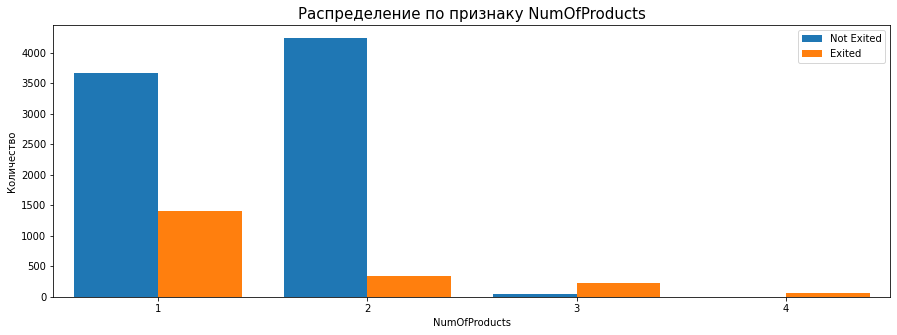

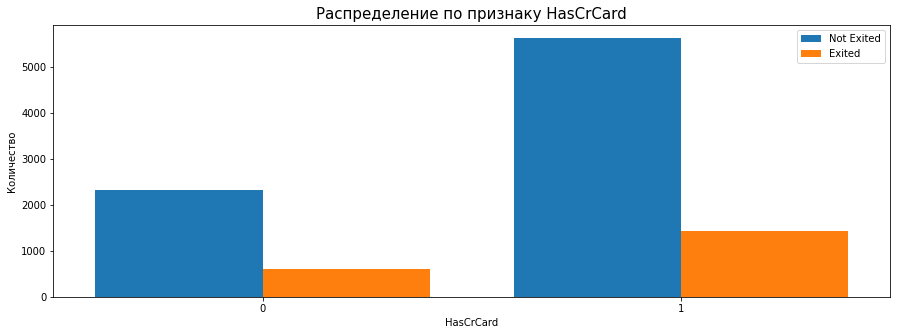

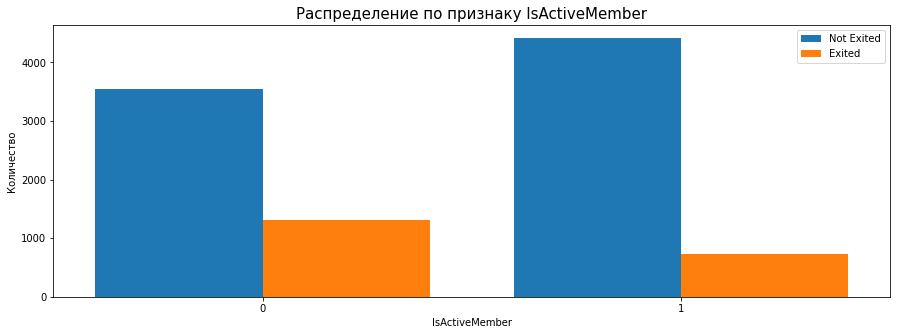

In [19]:
for column in ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']:
    plt.figure(figsize=(15,5))
    ax = sns.countplot(data=df, x=df[column], hue='Exited', saturation=1)
    ax.set_title('Распределение по признаку ' +column, fontsize=15, color='black')
    plt.ylabel('Количество', fontsize = 10, color='black')
    plt.xlabel(column, fontsize=10, color='black')
    ax.legend(['Not Exited', 'Exited'], loc=1, fontsize=10)
plt.show()

Явно видим, что классы несбалансированы.

Сравним работу моделей с константной моделью.

In [20]:
target_pred_constant = pd.Series(0, target.index)
accuracy_score(target, target_pred_constant)

0.7963

Так как построенные модели предсказывают уход клиентов лучше, чем константная, считаем что они адекватны. Но попробуем применить другую методику и посмотрим, что можем увидеть, используя её. Применим F1-меру (среднее гармоническое полноты и точности), чтобы оценить качество прогноза положительного класса у моделей.

In [21]:
f1_score(target_valid, predicted_valid_lr)

0.3344947735191638

In [22]:
f1_score(target_valid, predicted_valid_rf)

0.5884146341463414

**Вывод:**

- исследовали баланс классов - классы несбалансированы,
- при делении клиентов на группы ушедших и оставшихся, выяснили, что клиенты уходят примерно в 20% процентах случаев, те положительный класс меньше отрицательного в 4 раза,
- изучили модели без учёта дисбаланса
- поняли, что модель случайного леса лучше

Давайте теперь попробуем выполнить условие задания - F1 >= 0.59

## Борьба с дисбалансом

In [23]:
# Напишем общую функцию вывода пропорции классов
def proportion_func(target):
    proportion = target.value_counts(normalize=True)
    print(proportion)
    proportion.plot(kind='bar')

In [24]:
# Напишем общую функцию для вывода ROC-AUC
def roc_auc_func(feature, target, model):
    probabilities_valid = model.predict_proba(feature)
    probabilities_one_valid = probabilities_valid[:, 1]
    rf_auc = roc_auc_score(target, probabilities_one_valid)
    fpr, tpr, treshold = roc_curve(target, probabilities_one_valid)
    roc_auc = auc(fpr, tpr)

    # Cтроим график
    plt.plot(fpr, tpr, color='darkorange', label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()

**Попробуем сбалансировать классы**

In [25]:
logistic_regression_func(features_train, target_train, features_valid, target_valid, 'balanced')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ............................model__solver=newton-cg; total time=   0.1s
[CV] END ............................model__solver=newton-cg; total time=   0.2s
[CV] END ............................model__solver=newton-cg; total time=   0.3s
[CV] END ................................model__solver=lbfgs; total time=   0.2s
[CV] END ................................model__solver=lbfgs; total time=   0.2s
[CV] END ................................model__solver=lbfgs; total time=   0.2s
[CV] END ............................model__solver=liblinear; total time=   0.1s
[CV] END ............................model__solver=liblinear; total time=   0.2s
[CV] END ............................model__solver=liblinear; total time=   0.2s
[CV] END ..................................model__solver=sag; total time=   0.2s
[CV] END ..................................model__solver=sag; total time=   0.2s
[CV] END ..................................model_

(Pipeline(steps=[('scale', StandardScaler()),
                 ('model',
                  LogisticRegression(class_weight='balanced', random_state=777,
                                     solver='newton-cg'))]),
 {'model__solver': 'newton-cg'},
 0       0
 1       0
 2       1
 3       1
 4       0
        ..
 1995    1
 1996    1
 1997    0
 1998    0
 1999    1
 Length: 2000, dtype: int64)

0    0.796333
1    0.203667
Name: Exited, dtype: float64


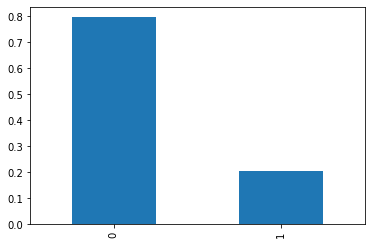

In [26]:
proportion_func(target_train)

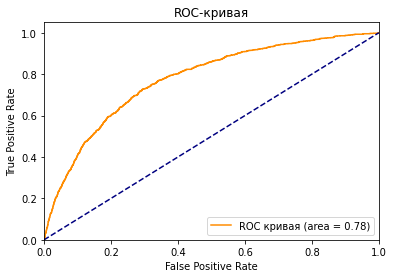

In [27]:
roc_auc_func(features_train, target_train, model)

In [28]:
rand_forest_func(features_train, target_train, 'balanced')

100%|██████████| 9/9 [00:23<00:00,  2.56s/it]

Оптимальная глубина дерева: 8
Оптимальное количество деревьев: 10
Минимум объектов в узле: 3
Лучшее качество: 0.8305
F1-мера: 0.6178128523111612
ROC-AUC метрика: 0.8447997725460625


0       0
1       0
2       0
3       0
4       0
       ..
1995    0
1996    0
1997    1
1998    0
1999    1
Length: 2000, dtype: int64

Мера F1 выглядит намного лучше, у модели LogisticRegression она увеличилась почти в 2 раза.

0    0.796333
1    0.203667
Name: Exited, dtype: float64


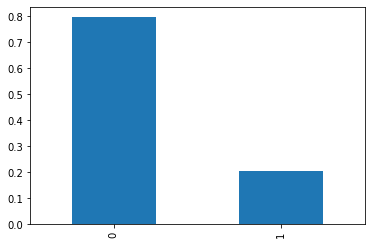

In [29]:
proportion_func(target_train)

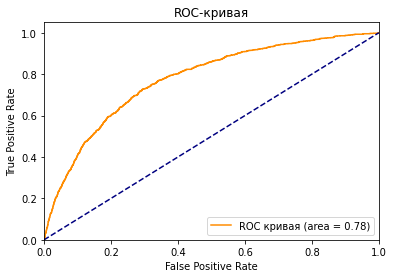

In [30]:
roc_auc_func(features_train, target_train, model)

**Попробуем уменьшить выборку**

In [31]:
# Напишем функцию downsample
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=777)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=777)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=777)
    
    return features_downsampled, target_downsampled

In [32]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [33]:
print(features_downsampled.shape)

(2416, 11)


In [34]:
print(target_downsampled.shape)

(2416,)


In [35]:
logistic_regression_func(features_downsampled, target_downsampled, features_valid, target_valid, None)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ............................model__solver=newton-cg; total time=   0.0s
[CV] END ............................model__solver=newton-cg; total time=   0.1s
[CV] END ............................model__solver=newton-cg; total time=   0.2s
[CV] END ................................model__solver=lbfgs; total time=   0.2s
[CV] END ................................model__solver=lbfgs; total time=   0.2s
[CV] END ................................model__solver=lbfgs; total time=   0.1s
[CV] END ............................model__solver=liblinear; total time=   0.1s
[CV] END ............................model__solver=liblinear; total time=   0.0s
[CV] END ............................model__solver=liblinear; total time=   0.0s
[CV] END ..................................model__solver=sag; total time=   0.0s
[CV] END ..................................model__solver=sag; total time=   0.0s
[CV] END ..................................model_

(Pipeline(steps=[('scale', StandardScaler()),
                 ('model',
                  LogisticRegression(random_state=777, solver='newton-cg'))]),
 {'model__solver': 'newton-cg'},
 0       0
 1       0
 2       1
 3       1
 4       0
        ..
 1995    1
 1996    1
 1997    0
 1998    0
 1999    1
 Length: 2000, dtype: int64)

1    0.505795
0    0.494205
Name: Exited, dtype: float64


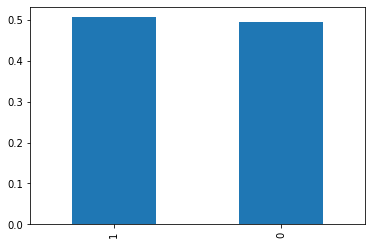

In [36]:
proportion_func(target_downsampled)

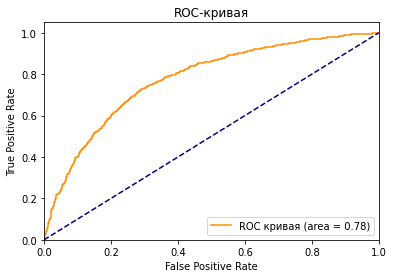

In [37]:
roc_auc_func(features_downsampled, target_downsampled, model)

In [38]:
rand_forest_func(features_downsampled, target_downsampled, None)

100%|██████████| 9/9 [00:15<00:00,  1.70s/it]

Оптимальная глубина дерева: 9
Оптимальное количество деревьев: 30
Минимум объектов в узле: 2
Лучшее качество: 0.797
F1-мера: 0.6019607843137255
ROC-AUC метрика: 0.8513977909772484


0       0
1       1
2       0
3       0
4       0
       ..
1995    0
1996    0
1997    1
1998    0
1999    1
Length: 2000, dtype: int64

1    0.505795
0    0.494205
Name: Exited, dtype: float64


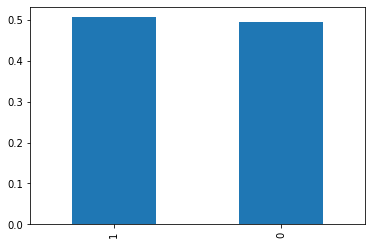

In [39]:
proportion_func(target_downsampled)

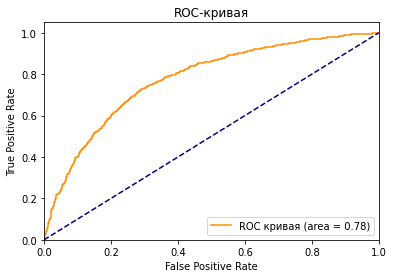

In [40]:
roc_auc_func(features_downsampled, target_downsampled, model)

**Попробуем увеличить выборку**

In [41]:
# Напишем функцию upsample
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [42]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [43]:
print(features_upsampled.shape)

(9666, 11)


In [44]:
print(target_upsampled.shape)

(9666,)


In [45]:
logistic_regression_func(features_upsampled, target_upsampled, features_valid, target_valid, None)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ............................model__solver=newton-cg; total time=   0.2s
[CV] END ............................model__solver=newton-cg; total time=   0.3s
[CV] END ............................model__solver=newton-cg; total time=   0.2s
[CV] END ................................model__solver=lbfgs; total time=   0.1s
[CV] END ................................model__solver=lbfgs; total time=   0.2s
[CV] END ................................model__solver=lbfgs; total time=   0.3s
[CV] END ............................model__solver=liblinear; total time=   0.2s
[CV] END ............................model__solver=liblinear; total time=   0.2s
[CV] END ............................model__solver=liblinear; total time=   0.2s
[CV] END ..................................model__solver=sag; total time=   0.2s
[CV] END ..................................model__solver=sag; total time=   0.2s
[CV] END ..................................model_

(Pipeline(steps=[('scale', StandardScaler()),
                 ('model',
                  LogisticRegression(random_state=777, solver='newton-cg'))]),
 {'model__solver': 'newton-cg'},
 0       0
 1       0
 2       1
 3       1
 4       0
        ..
 1995    1
 1996    1
 1997    0
 1998    0
 1999    1
 Length: 2000, dtype: int64)

1    0.50569
0    0.49431
Name: Exited, dtype: float64


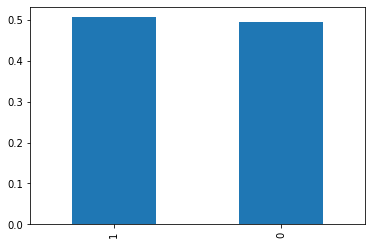

In [46]:
proportion_func(target_upsampled)

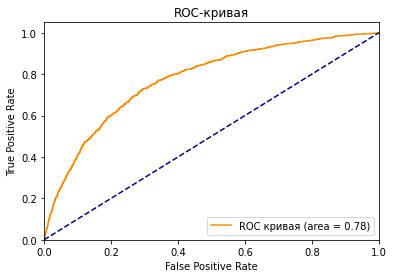

In [47]:
roc_auc_func(features_upsampled, target_upsampled, model)

In [48]:
rand_forest_func(features_upsampled, target_upsampled, None)

100%|██████████| 9/9 [00:29<00:00,  3.27s/it]

Оптимальная глубина дерева: 9
Оптимальное количество деревьев: 25
Минимум объектов в узле: 2
Лучшее качество: 0.8175
F1-мера: 0.6045503791982665
ROC-AUC метрика: 0.8499731134611936


0       0
1       0
2       0
3       0
4       0
       ..
1995    0
1996    0
1997    1
1998    0
1999    1
Length: 2000, dtype: int64

1    0.50569
0    0.49431
Name: Exited, dtype: float64


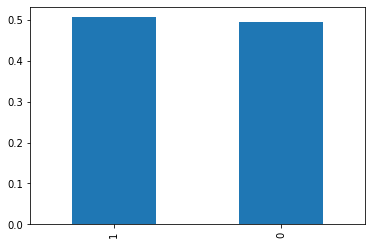

In [49]:
proportion_func(target_upsampled)

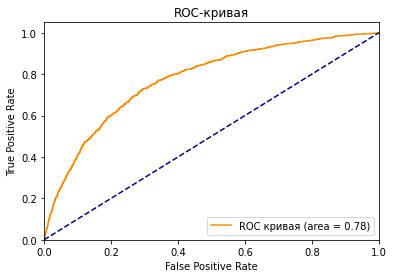

In [50]:
roc_auc_func(features_upsampled, target_upsampled, model)

**Попробуем изменить порог**

In [51]:
# Напишем функцию для подсчета F1 при разном значении порога
def change_threshold_func(probabilities_one_valid):
    for threshold in np.arange(0, 0.6, 0.05):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_valid, predicted_valid)
        print("Порог = {:.2f} | F1 = {:.3f}".format(threshold, f1))

In [52]:
# Логистическая регрессия
model = LogisticRegression(random_state=777, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid_lr = model.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

In [53]:
change_threshold_func(probabilities_one_valid_lr)

Порог = 0.00 | F1 = 0.337
Порог = 0.05 | F1 = 0.368
Порог = 0.10 | F1 = 0.419
Порог = 0.15 | F1 = 0.455
Порог = 0.20 | F1 = 0.468
Порог = 0.25 | F1 = 0.469
Порог = 0.30 | F1 = 0.461
Порог = 0.35 | F1 = 0.442
Порог = 0.40 | F1 = 0.405
Порог = 0.45 | F1 = 0.359
Порог = 0.50 | F1 = 0.334
Порог = 0.55 | F1 = 0.287


0    0.796333
1    0.203667
Name: Exited, dtype: float64


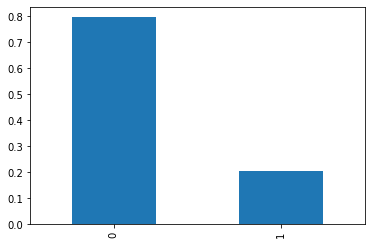

In [54]:
proportion_func(target_train)

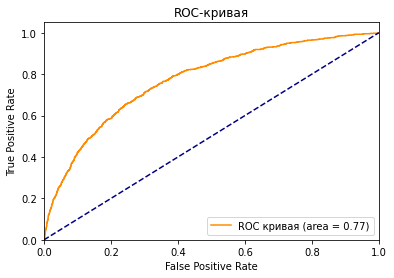

In [55]:
roc_auc_func(features_train, target_train, model)

In [56]:
# Случайный лес возьмем с нашими лучшими значениями параметров
model = RandomForestClassifier(max_depth=9, n_estimators=35, min_samples_leaf=3, random_state=777)
model.fit(features_train, target_train)
probabilities_valid_rf = model.predict_proba(features_valid)
probabilities_one_valid_rf = probabilities_valid_rf[:, 1]

In [57]:
change_threshold_func(probabilities_one_valid_rf)

Порог = 0.00 | F1 = 0.337
Порог = 0.05 | F1 = 0.389
Порог = 0.10 | F1 = 0.487
Порог = 0.15 | F1 = 0.554
Порог = 0.20 | F1 = 0.587
Порог = 0.25 | F1 = 0.602
Порог = 0.30 | F1 = 0.622
Порог = 0.35 | F1 = 0.640
Порог = 0.40 | F1 = 0.628
Порог = 0.45 | F1 = 0.608
Порог = 0.50 | F1 = 0.578
Порог = 0.55 | F1 = 0.558


0    0.796333
1    0.203667
Name: Exited, dtype: float64


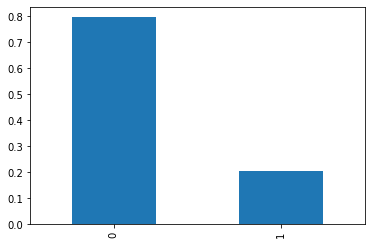

In [58]:
proportion_func(target_train)

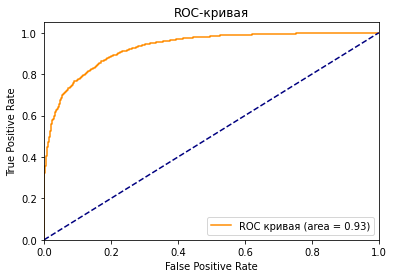

In [59]:
roc_auc_func(features_train, target_train, model)

**Попробуем RandomOverSampler**

In [60]:
# Создание экземпляра RandomOverSampler
ros = RandomOverSampler()

# Применение увеличения выборки к данным
X_resampled, y_resampled = ros.fit_resample(features_train, target_train)

In [61]:
print(X_resampled.shape)

(9556, 11)


In [62]:
print(y_resampled.shape)

(9556,)


0    0.5
1    0.5
Name: Exited, dtype: float64


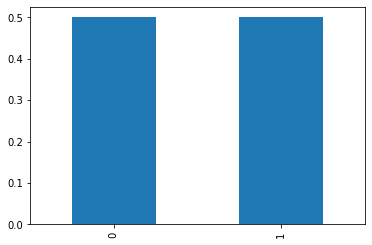

In [63]:
proportion_func(y_resampled)

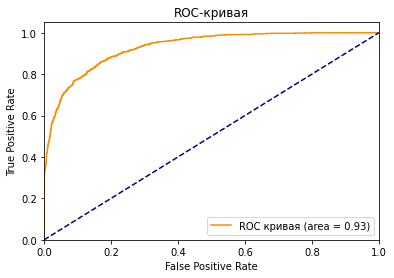

In [64]:
roc_auc_func(X_resampled, y_resampled, model)

**Попробуем Undersampling**

In [65]:
# Создание экземпляра RandomUnderSampler
rus = RandomUnderSampler()

# Применение уменьшения выборки к данным
X_resampled, y_resampled = rus.fit_resample(features_train, target_train)

In [66]:
print(X_resampled.shape)

(2444, 11)


In [67]:
print(y_resampled.shape)

(2444,)


0    0.5
1    0.5
Name: Exited, dtype: float64


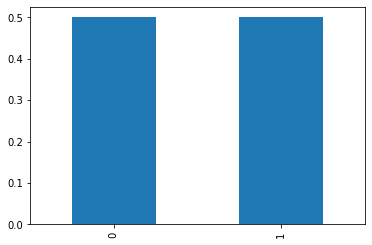

In [68]:
proportion_func(y_resampled)

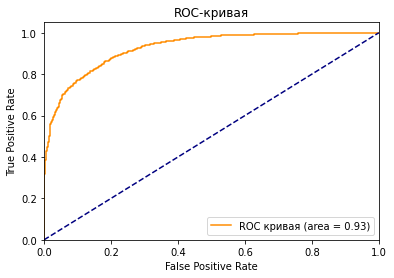

In [69]:
roc_auc_func(X_resampled, y_resampled, model)

**Попробуем SMOTE**

In [70]:
# Создание экземпляра SMOTE
smote = SMOTE()

# Применение SMOTE к данным
X_resampled, y_resampled = smote.fit_resample(features_train, target_train)

In [71]:
print(X_resampled.shape)

(9556, 11)


In [72]:
print(y_resampled.shape)

(9556,)


0    0.5
1    0.5
Name: Exited, dtype: float64


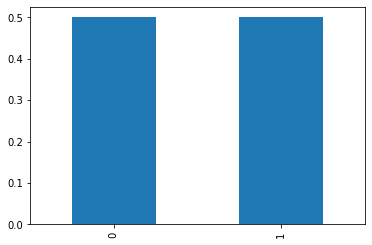

In [73]:
proportion_func(y_resampled)

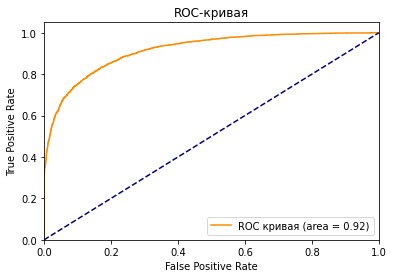

In [74]:
roc_auc_func(X_resampled, y_resampled, model)

**Вывод:**

Лучшие всего показал себя RandomForestClassifier со значениями n_estimators = 35 и max_depth = 9 в комбинации с class_weight='balanced'. Далее их и будем использовать. Логистическая регрессия не так эффективна, как и уменьшение или увеличение выборки.

## Тестирование модели

In [75]:
# Обучим финальную модель и проверим её на тестовой выборке
model = RandomForestClassifier(max_depth=9, n_estimators=35, class_weight='balanced', random_state=777)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
f1_score(target_test, predicted_test)

0.6046511627906976

Нужное значение F1-меры в 0,59 достигнуто и превышено.

Посчитаем площадь под ROC-кривой для модели (AUC-ROC), чтобы узнать, насколько сильно ее точность отличается от случайной.

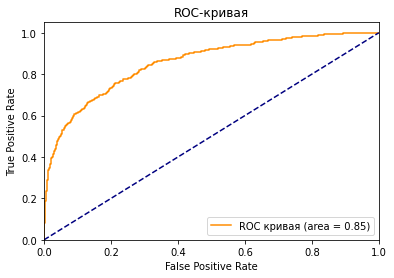

In [76]:
roc_auc_func(features_test, target_test, model)

Метрика AUC-ROC почти не отличается от значения для случайной модели (0.5). F1 оценила построенную модель выше.

## Общий вывод

Основная цель проекта достигнута - проанализированы данные «Бета-Банка» и достигнуто значение F1-меры более 0,59. 

**Итого:**
- загружены и выведены общие данные по датасету
- обработали данные:
    - избавились от столбцов RowNumber, CustomerId, Surname
    - заменили NaN-значения в столбце Tenure на 0
    - столбцы Geography и Gender преобразовали в численные с помощью One-Hot Encoding
- разбили датасет на 3 выборки - обучающую, валидационную и тестовую
- масштабировали признаки методом стандартизации
- исследовали целевой признак, чтобы оценить адекватность модели
- попробовали сбалансировать классы (так как они оказались несбалансированы) и выяснили, что RandomForestClassifier со значениями n_estimators = 35 и max_depth = 9 в комбинации с class_weight='balanced' подходит нам больше всего. Логистическая регрессия оказалась не так эффективна, как и уменьшение или увеличение выборки
- при тестировании модели достигли значения F1-меры = 0.6374331550802139
- оказалось, что AUC-ROC почти не отличается от значения для случайной модели (0.5)